In [1]:
import torch.nn.functional as F
from torchvision import transforms 
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from torch import nn
import math
from torch.optim import Adam
import tqdm

from useful_functions_notebook_14to18 import *
from useful_functions_notebook_8to13 import variable_consistancy_check, mass_not_preserved_percentage_decrease, check_branch_length, analyze_data

from IPython.display import display, HTML
from IPython.display import display
display(HTML("<style>.container { width:70% !important; }</style>"))

In [2]:
generated_data_norm = torch.load("diffusion_notebook/diffusion_2.0/diffusion2.0_consistant_postporcessed_images", map_location = "cpu")
generated_data_norm.shape

torch.Size([38538, 3, 29, 10])

# Model

In [3]:
class Encoder(nn.Module):
    def __init__(self, nvar, nbr, latent_size):
        super().__init__()

        self.num_branches = nbr

        self.layers = nn.Sequential(
            nn.Conv2d(nvar, 16, kernel_size=(1, 3), stride=1),
            nn.ELU(),
            nn.Conv2d(16, 32, kernel_size=(1, 3), stride=1),
            nn.ELU(),
            nn.Conv2d(32, 64, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.Conv2d(64, 128, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.Conv2d(128, 256, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.Flatten()
            )
        
        if self.num_branches == 6:
            self.linear = nn.Linear(11776, latent_size)
        else:
            self.linear = nn.Linear(35328, latent_size)

    def forward(self, x, t = 0):
        x = self.layers(x)
        x = self.linear(x)
        return x


class Generator(nn.Module):
    def __init__(self, nvar, nbr, latent_size):
        super().__init__()

        self.num_branches = nbr

        self.layers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.ConvTranspose2d(128, 64, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.ConvTranspose2d(64, 32, kernel_size=(3, 1), stride=1),
            nn.ELU(),
            nn.ConvTranspose2d(32, 16, kernel_size=(1, 3), stride=1),
            nn.ELU(),
            nn.ConvTranspose2d(16, nvar, kernel_size=(1, 3), stride=1),
            #nn.Sigmoid()
            nn.ReLU()
        )
        
        if self.num_branches == 6:
            self.linear = nn.Linear(latent_size, 11776)
        else:
            self.linear = nn.Linear(latent_size, 35328)
        self.elu = nn.ELU()


    def forward(self, x, t = 0):
        x = self.elu(self.linear(x))
        if self.num_branches == 6:
            x = x.view(-1, 256, 23, 2)
        else:
            x = x.view(-1, 256, 23, 6)

        return self.layers(x)
        

# load pretrained weights

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator_path = "../notebooks/models/fox_attempt1/generator_fox_test.pt"
encoder_path = "../notebooks/models/fox_attempt1/encoder_fox_test.pt"

saved_generator = torch.load(generator_path, map_location = device)
generator_state_dict = saved_generator["generator"]
latent_dim = saved_generator["latent_space"]
num_branches = saved_generator["num_branches"]
nvar = saved_generator["nvar"]

generator = Generator(nvar, num_branches, latent_dim)
generator.load_state_dict(generator_state_dict)

saved_encoder = torch.load(encoder_path, map_location = device)
encoder_state_dict = saved_encoder["encoder"]

generator = Generator(nvar, num_branches, latent_dim)
encoder = Encoder(nvar, num_branches, latent_dim)
encoder.load_state_dict(encoder_state_dict)

<All keys matched successfully>

# reconstruct original data

orignal sample:
torch.Size([5, 3, 29, 10])


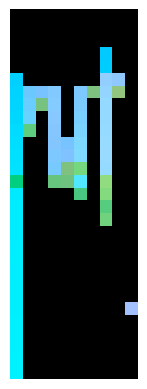

latent representation:
torch.Size([5, 300])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed sample:
torch.Size([5, 3, 29, 10])


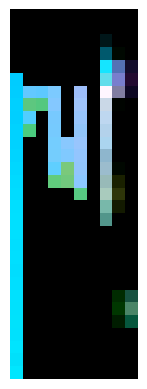

In [5]:
data_path = "data/dataset_distlognorm_massnorm.pt"
data = torch.load(data_path)
sample = data[1237:1237 + 5]
print("orignal sample:")
print(sample.shape)
plt.imshow(sample[0].detach().permute(1, 2, 0))
plt.axis('off')  # Optional: Turn off axis ticks and labels
plt.show()

latent = encoder(sample.to(dtype=torch.float32))
print("latent representation:")
print(latent.shape)
plt.imshow(latent.detach())
plt.axis('off')  # Optional: Turn off axis ticks and labels
plt.show()


recon = generator(latent)

print("reconstructed sample:")
print(recon.shape)
plt.imshow(recon[0].detach().permute(1, 2, 0))
plt.axis('off')  # Optional: Turn off axis ticks and labels
plt.show()


# generate sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


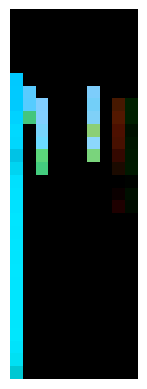

In [25]:
batch_size = 1
high = 1.0
low = -1.0
uniform_noise = torch.rand(batch_size, latent_dim) * (high - (low)) + (low)
noise = uniform_noise.to(device)

noise = torch.randn(batch_size, latent_dim).to(device)

fake_image = generator(noise)

plt.imshow(fake_image[0].detach().permute(1, 2, 0))
plt.axis('off')  # Optional: Turn off axis ticks and labels
plt.show()

# latent diffusion

In [33]:
generator = generator
encoder = encoder
latent_dim = latent_dim
latent_dim

300

### latent diffusion model

In [113]:
latent.shape

torch.Size([5, 300])

latent representation:
torch.Size([5, 300])


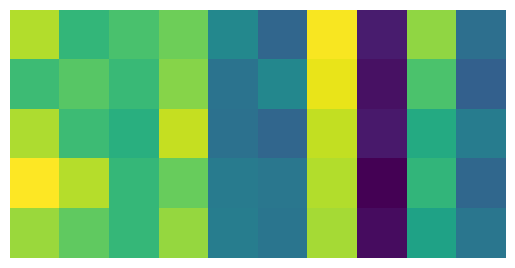

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([5, 3, 10, 10])


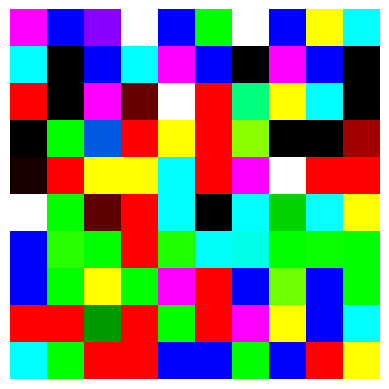

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([5, 3, 64, 64])


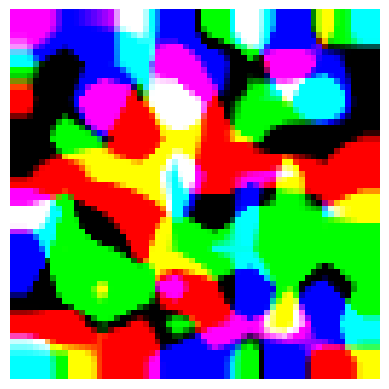

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([5, 3, 10, 10])


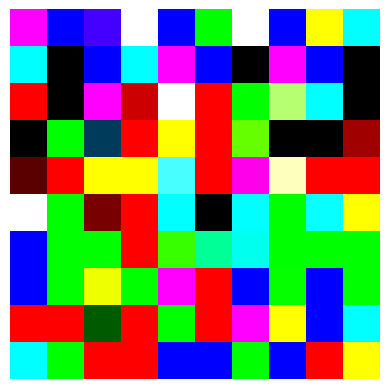

torch.Size([1, 5, 300])


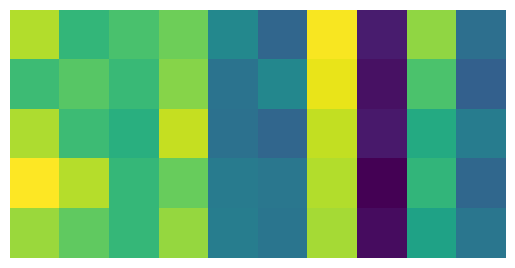

In [122]:
print("latent representation:")
print(latent.shape)
plt.imshow(latent[:, :10].detach())
plt.axis('off')  # Optional: Turn off axis ticks and labels
plt.show()

latent_test = latent.view(-1, 3, 10, 10)
print(latent_test.shape)
plt.imshow(latent_test[0].detach().permute(1, 2, 0))
plt.axis('off')  # Optional: Turn off axis ticks and labels
plt.show()


transform = transforms.Resize((64, 64))
latent_test2 = transform(latent_test)
print(latent_test2.shape)
plt.imshow(latent_test2[0].detach().permute(1, 2, 0))
plt.axis('off')  # Optional: Turn off axis ticks and labels
plt.show()

transform_back = transforms.Resize((10, 10))
latent_test3 = transform_back(latent_test2)
print(latent_test3.shape)
plt.imshow(latent_test3[0].detach().permute(1, 2, 0))
plt.axis('off')  # Optional: Turn off axis ticks and labels
plt.show()


latent_test4 = latent.view(-1, 300).unsqueeze(0)
print(latent_test4.shape)
plt.imshow(latent_test4[0, :, :10].detach())
plt.axis('off')  # Optional: Turn off axis ticks and labels
plt.show()

In [62]:
for param in generator.parameters():
    param.requires_grad = False
    
for param in encoder.parameters():
    param.requires_grad = False



In [207]:
T = 1000
lr = 3e-4
epochs = 5
test_data = transform(data[:16])
dataloader = DataLoader(test_data, batch_size = batch_size, shuffle = True)

latent_diffusion_model = SimpleUnet()

trained_latent_diffusion = diffusion_train(latent_diffusion_model, dataloader, epochs, lr, T, device)


epoch 1 / 5


  0%|                                                    | 0/16 [00:00<?, ?it/s]

torch.Size([1, 3, 64, 64])


100%|███████████████████████████████████████████| 16/16 [00:21<00:00,  1.33s/it]


Epoch 1 | step 016 Loss: 0.6616506576538086 
epoch 2 / 5


100%|███████████████████████████████████████████| 16/16 [00:20<00:00,  1.30s/it]


Epoch 2 | step 016 Loss: 0.5128757357597351 
epoch 3 / 5


100%|███████████████████████████████████████████| 16/16 [00:20<00:00,  1.30s/it]


Epoch 3 | step 016 Loss: 0.40172386169433594 
epoch 4 / 5


100%|███████████████████████████████████████████| 16/16 [00:17<00:00,  1.12s/it]


Epoch 4 | step 016 Loss: 0.33758997917175293 
epoch 5 / 5


100%|███████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]

Epoch 5 | step 016 Loss: 0.29013946652412415 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 64, 64])


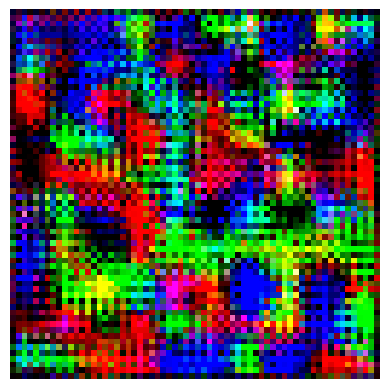

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 64, 64])


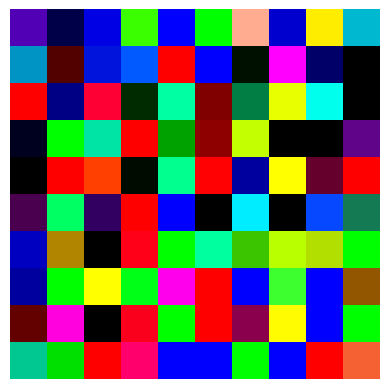

torch.Size([1, 300])


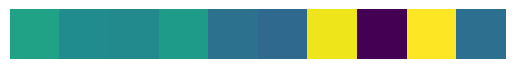

In [89]:
T = 1000
t = torch.randint(0, T, (batch_size,), device=device).long()
test_result = latent_test2.unsqueeze(0)
out_test = trained_latent_diffusion(test_result, t)

print(out_test.shape)
plt.imshow(out_test[0].detach().permute(1, 2, 0))
plt.axis('off')  # Optional: Turn off axis ticks and labels
plt.show()

out_test2 = transform_back(out_test)
print(out_test.shape)
plt.imshow(out_test2[0].detach().permute(1, 2, 0))
plt.axis('off')  # Optional: Turn off axis ticks and labels
plt.show()

out_test3 = out_test2.view(300).unsqueeze(0)
print(out_test3.shape)
plt.imshow(out_test3[:, :10].detach())
plt.axis('off')  # Optional: Turn off axis ticks and labels
plt.show()

Epoch: 1 / 5


100%|███████████████████████████████████████████| 16/16 [00:21<00:00,  1.33s/it]

Epoch 1 | Loss: 0.7079032063484192 


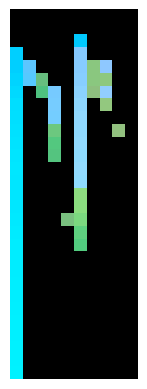

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


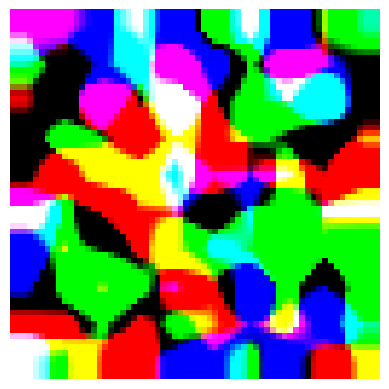

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


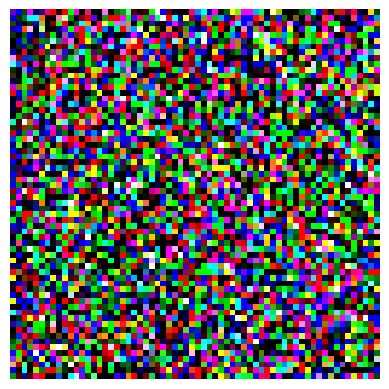

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


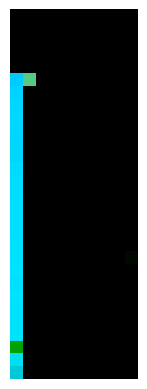

Epoch: 2 / 5


100%|███████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]

Epoch 2 | Loss: 0.6113216876983643 


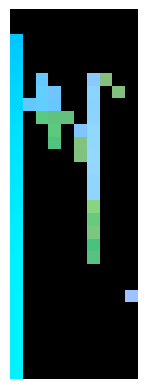

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


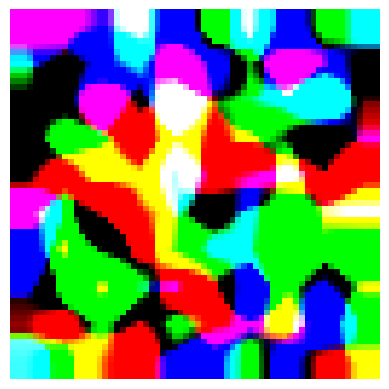

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


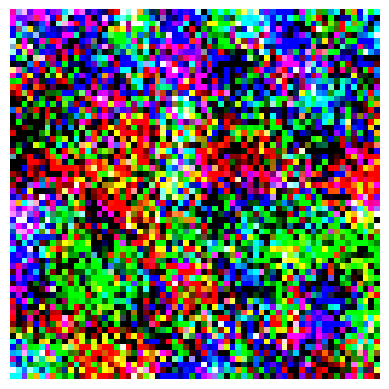

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


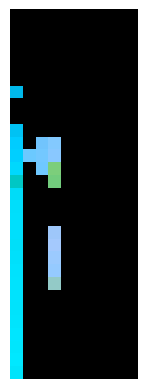

Epoch: 3 / 5


100%|███████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]

Epoch 3 | Loss: 0.5164665579795837 


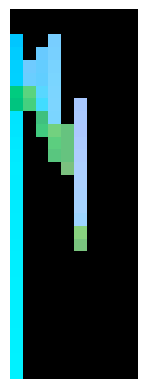

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


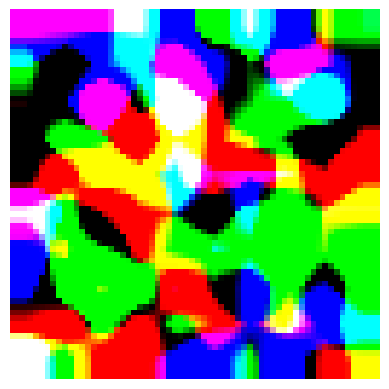

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


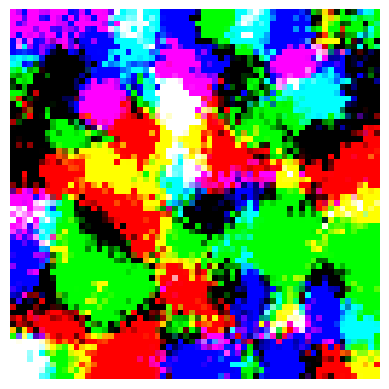

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


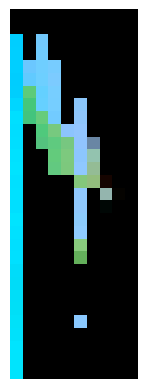

Epoch: 4 / 5


100%|███████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]

Epoch 4 | Loss: 0.40321001410484314 


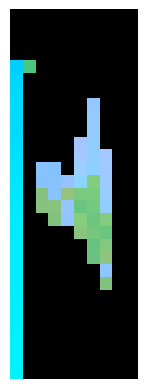

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


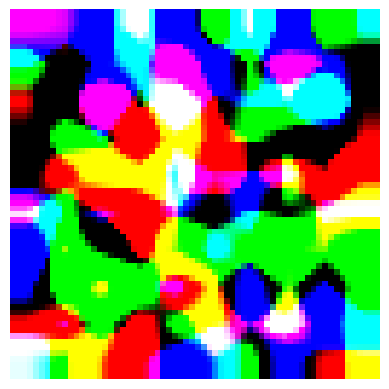

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


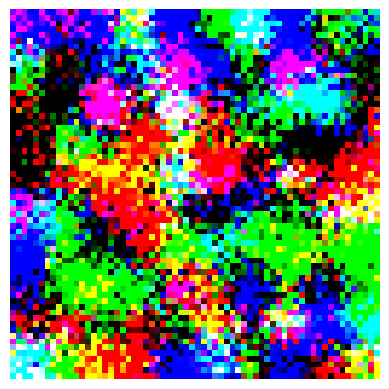

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


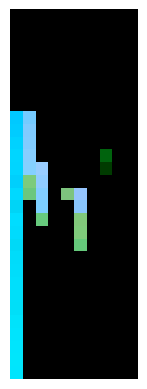

Epoch: 5 / 5


100%|███████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]

Epoch 5 | Loss: 0.38380905985832214 


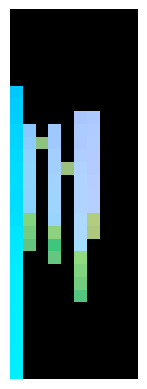

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


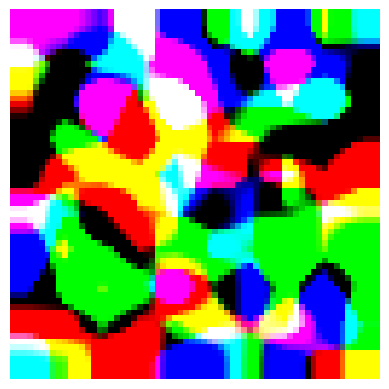

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


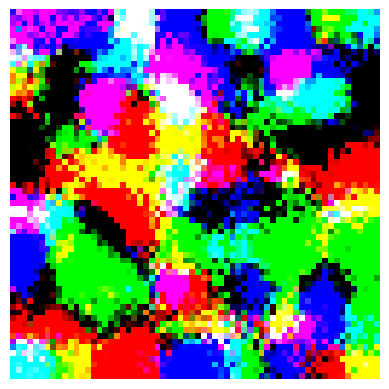

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


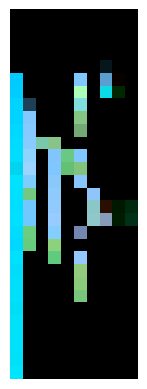

In [212]:
# load dataset
data_path = "data/dataset_distlognorm_massnorm.pt"
data = torch.load(data_path)
bs = 16
sample = data[:bs]
dataloader_diff = DataLoader(sample, batch_size = batch_size, shuffle = True)

# hyperparameters
T = 1000
epochs = 5
lr = 3e-4
train_encoder_generator = False

# load models
latent_diffusion_model = SimpleUnet()

generator_path = "../notebooks/models/fox_attempt1/generator_fox_test.pt"
encoder_path = "../notebooks/models/fox_attempt1/encoder_fox_test.pt"

saved_generator = torch.load(generator_path, map_location = device)
generator_state_dict = saved_generator["generator"]
latent_dim = saved_generator["latent_space"]
num_branches = saved_generator["num_branches"]
nvar = saved_generator["nvar"]

generator = Generator(nvar, num_branches, latent_dim)
generator.load_state_dict(generator_state_dict)

saved_encoder = torch.load(encoder_path, map_location = device)
encoder_state_dict = saved_encoder["encoder"]

encoder = Encoder(nvar, num_branches, latent_dim)
encoder.load_state_dict(encoder_state_dict)

# freeze encoder and generator
for param in generator.parameters():
    param.requires_grad = train_encoder_generator
    
for param in encoder.parameters():
    param.requires_grad = train_encoder_generator



encoder_test, decodertest, latent_diffusion_modeltest = training_latent_diffusion(encoder,
                                                                                  generator,
                                                                                  latent_diffusion_model,
                                                                                  dataloader_diff,
                                                                                  epochs,
                                                                                  lr,
                                                                                  T,
                                                                                  device,
                                                                                  pretrained = True)

# Generate

In [83]:
latent_diffusion_model = SimpleUnet()
generator = Generator(nvar, num_branches, latent_dim)

latent_diffusion_path = "../notebooks/diffusion_notebook/latent_diffusion/1.0/latent_diffusion_model1.0.pt"
generator_path = "../notebooks/diffusion_notebook/latent_diffusion/1.0/generator_model1.0.pt"

saved_generator_model1 = torch.load(generator_path, map_location = device)
generator.load_state_dict(saved_generator_model1)

saved_latent_model1 = torch.load(latent_diffusion_path, map_location = device)
latent_diffusion_model.load_state_dict(saved_latent_model1)

<All keys matched successfully>

# using uniform noise to generate latent noise of sixe 300

In [86]:
transform = transforms.Resize((64, 64))
transform_back = transforms.Resize((10, 10))
T = 1000


high = 1.0
low = -1.0
noise = torch.rand(1, 300) * (high - (low)) + (low)
noise = torch.randn((1, 300), device=device)




noise_view = noise.view(-1, 3, 10, 10)
noise_reshape = transform(noise_view)
out_test = generated_image(latent_diffusion_model, noise_reshape, T)
latent_out = transform_back(out_test)
latent_out_view = latent_out.view(-1, 300)
output = generator(latent_out_view)

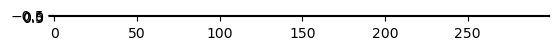

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


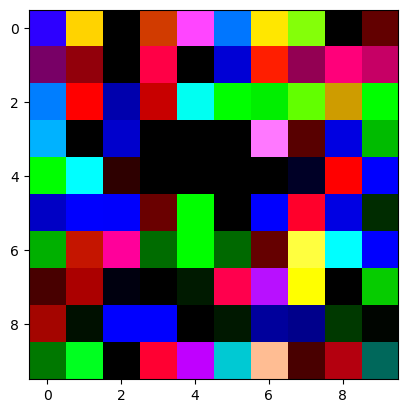

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


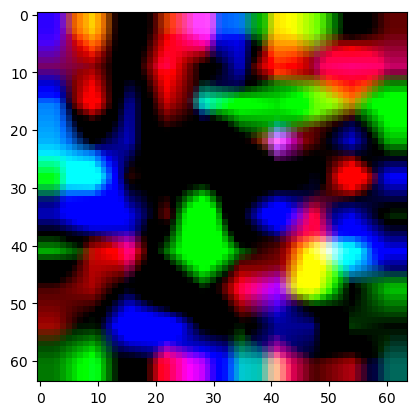

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


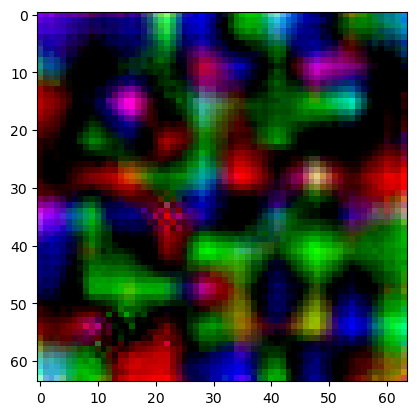

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


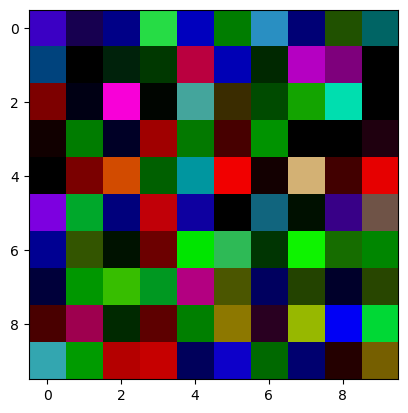

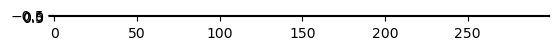

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


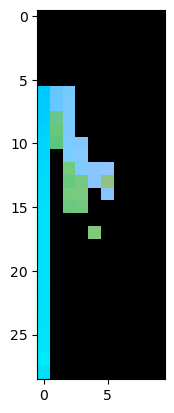

In [87]:
plt.imshow(noise.detach())
plt.show()

plt.imshow(noise_view[0].permute(1, 2, 0).detach())
plt.show()

plt.imshow(noise_reshape[0].permute(1, 2, 0).detach())
plt.show()

plt.imshow(out_test[0].permute(1, 2, 0).detach())
plt.show()

plt.imshow(latent_out[0].permute(1, 2, 0).detach())
plt.show()

plt.imshow(latent_out_view.detach())
plt.show()

plt.imshow(output[0].permute(1, 2, 0).detach())
plt.show()

# using uniform noise to generate latent noise of sixe 300

In [88]:
transform = transforms.Resize((64, 64))
transform_back = transforms.Resize((10, 10))
T = 1000


high = 1.0
low = -1.0
noise = torch.rand(1, 300) * (high - (low)) + (low)
#noise = torch.randn((1, 300), device=device)




noise_view = noise.view(-1, 3, 10, 10)
noise_reshape = transform(noise_view)
out_test = generated_image(latent_diffusion_model, noise_reshape, T)
latent_out = transform_back(out_test)
latent_out_view = latent_out.view(-1, 300)
output = generator(latent_out_view)

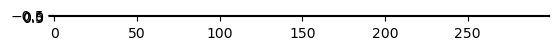

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


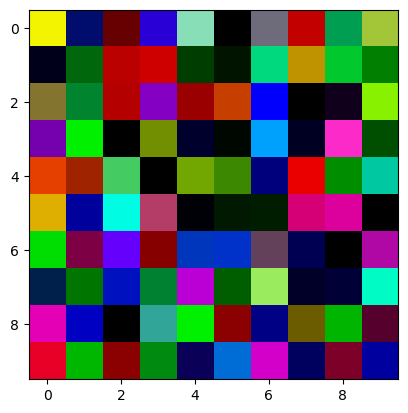

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


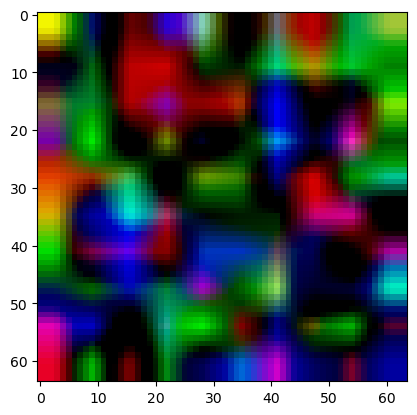

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


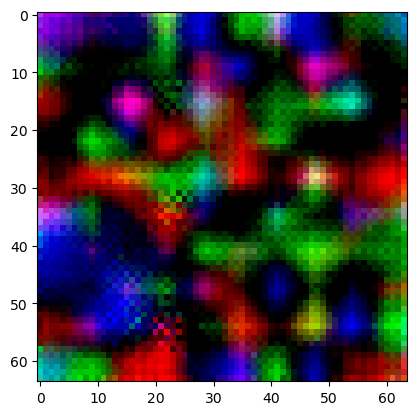

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


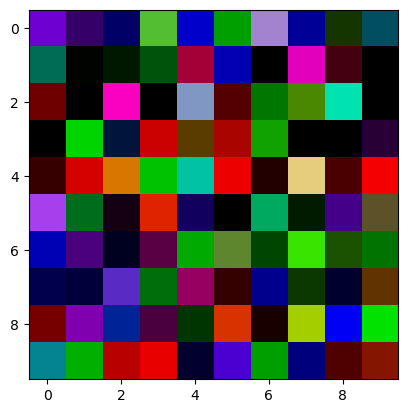

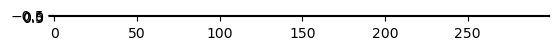

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


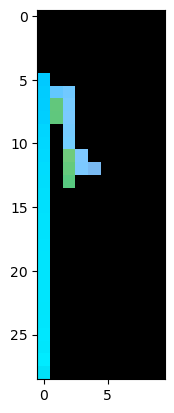

In [89]:

plt.imshow(noise.detach())
plt.show()

plt.imshow(noise_view[0].permute(1, 2, 0).detach())
plt.show()

plt.imshow(noise_reshape[0].permute(1, 2, 0).detach())
plt.show()

plt.imshow(out_test[0].permute(1, 2, 0).detach())
plt.show()

plt.imshow(latent_out[0].permute(1, 2, 0).detach())
plt.show()

plt.imshow(latent_out_view.detach())
plt.show()

plt.imshow(output[0].permute(1, 2, 0).detach())
plt.show()

# generating noise of size (3, 64, 64)

In [90]:
transform = transforms.Resize((64, 64))
transform_back = transforms.Resize((10, 10))
T = 1000


noise = torch.randn((1, 3, 64, 64), device=device)

out_test = generated_image(latent_diffusion_model, noise, T)
latent_out = transform_back(out_test)
latent_out_view = latent_out.view(-1, 300)
output = generator(latent_out_view)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


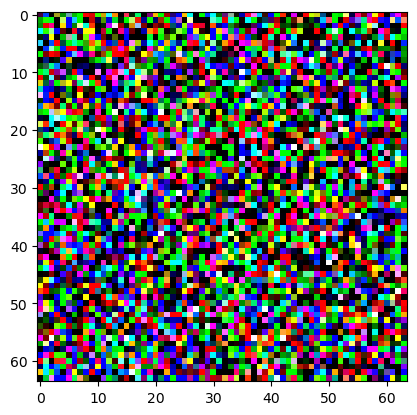

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


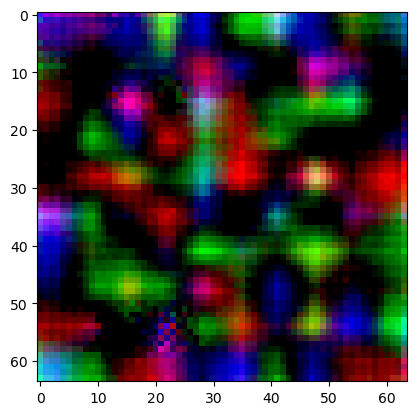

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


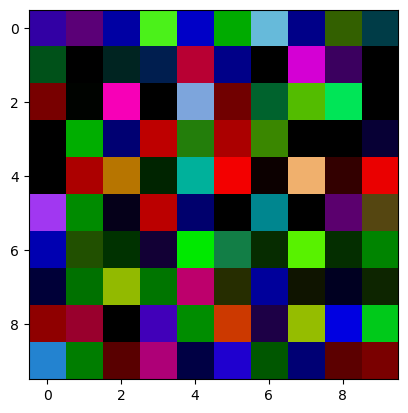

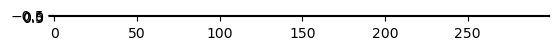

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


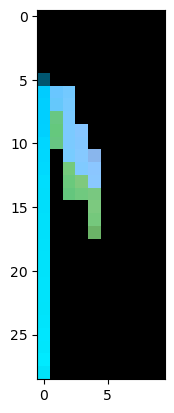

In [91]:

plt.imshow(noise[0].permute(1, 2, 0).detach())
plt.show()

plt.imshow(out_test[0].permute(1, 2, 0).detach())
plt.show()

plt.imshow(latent_out[0].permute(1, 2, 0).detach())
plt.show()

plt.imshow(latent_out_view.detach())
plt.show()

plt.imshow(output[0].permute(1, 2, 0).detach())
plt.show()

# all sampling methods work, lets look at some more images

In [92]:
transform = transforms.Resize((64, 64))
transform_back = transforms.Resize((10, 10))
T = 1000

noise = torch.randn((5, 300), device=device)

noise_view = noise.view(-1, 3, 10, 10)
noise_reshape = transform(noise_view)
out_test = generated_image(latent_diffusion_model, noise_reshape, T)
latent_out = transform_back(out_test)
latent_out_view = latent_out.view(-1, 300)
output = generator(latent_out_view)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


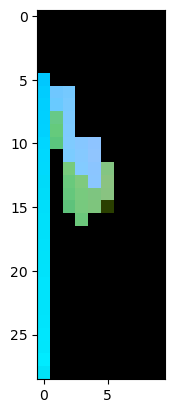

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


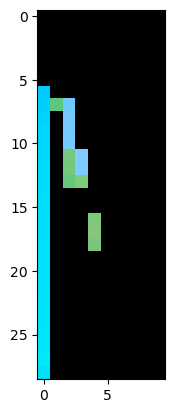

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


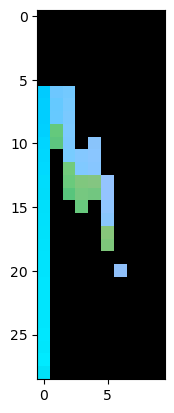

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


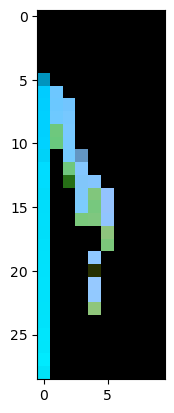

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


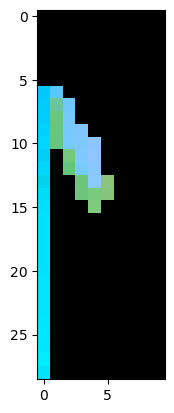

In [93]:
for im in output:
    plt.imshow(im.permute(1, 2, 0).detach())
    plt.show()

# results

/Users/corneliusbencsik/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


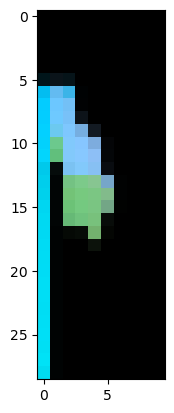

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


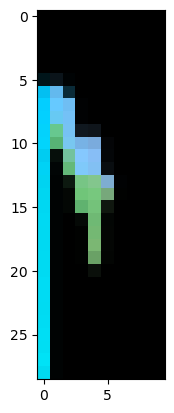

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


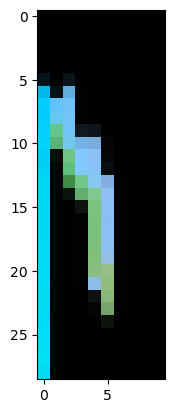

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


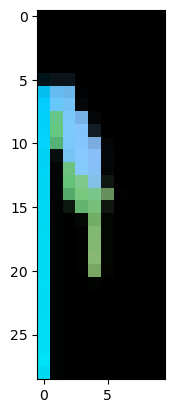

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


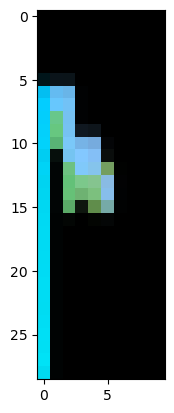

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


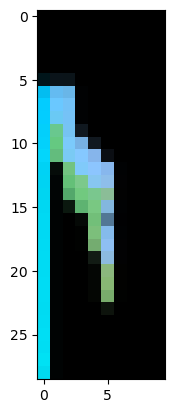

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


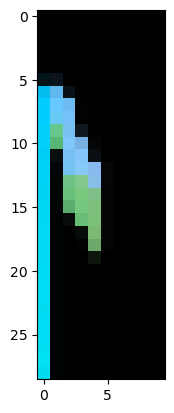

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


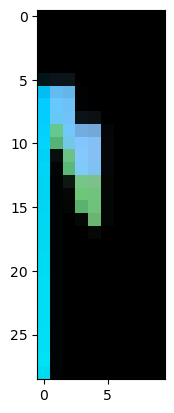

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


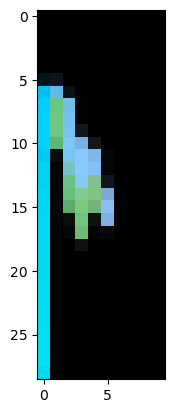

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


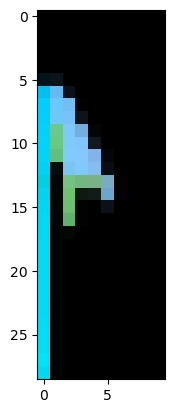

In [3]:
data_path1 = "diffusion_notebook/latent_diffusion/1.0/latent_diffusion_images1.0.pt"
data_path2 = "diffusion_notebook/latent_diffusion/1.0/latent_diffusion_images1.1.pt"
data_path3 = "diffusion_notebook/latent_diffusion/1.0/latent_diffusion_images1.2.pt"

data1 = torch.load(data_path1, map_location = "cpu")
data2 = torch.load(data_path2, map_location = "cpu")
data3 = torch.load(data_path3, map_location = "cpu")

data = torch.cat([data1,
                  data2,
                  data3
                 ], dim = 0)

transform = transforms.Resize((29, 10))
generated_data = transform(data.to(dtype=torch.float))
for im in generated_data[:10]:
    plt.imshow(im.permute(1, 2, 0).detach())
    plt.show()

In [4]:
check_branch_length(generated_data)
cons, incons = check_consistency(generated_data)

Complexity:
number of images with 1 branches is: 0
number of images with 2 branches is: 0
number of images with 3 branches is: 0
number of images with 4 branches is: 0
number of images with 5 branches is: 17
number of images with 6 branches is: 14052
number of images with 7 branches is: 24929
number of images with 8 branches is: 2
number of images with 9 branches is: 0
number of images with 10 branches is: 0

total images = 39000

average number of branches in an image = 6.64 vs. 7.12 in training data
Average branch length = 14.73 vs. 9.06 in training data
Average nonzero entries (progenitors) = 97.82 vs. 64.55 in training data





Percentage of consistant images = 0.0%

Inconsistency reasons:
inconsistency due to zero / nonzero mistake = 4.29%
inconsistency due to distance not zero in main branch =  100.00%
inconsistency due to gap between branches =  0.00%
inconsistency due to zgap in branch 8.43%
inconsistency due to last descendant dont exist 100.00%

Number of images with two or 

### only merger trees with 6 and 7 branches, whereas the same GAN (notebook 12 and 13) had branches varying from 1 - 10, where the most of the trees had 4 ot 5 branches, so diffusion pushes this up.

### in the original GAN; 35% of the images was consistent, here 0 are. additionaly 0% of the GAN images had distance in main branch not zero inconsistency, but with latent diffusion, all images have this inconsistency.

### most inconsistencies are due to zeroes in the main branch, so lets do a quickfix:

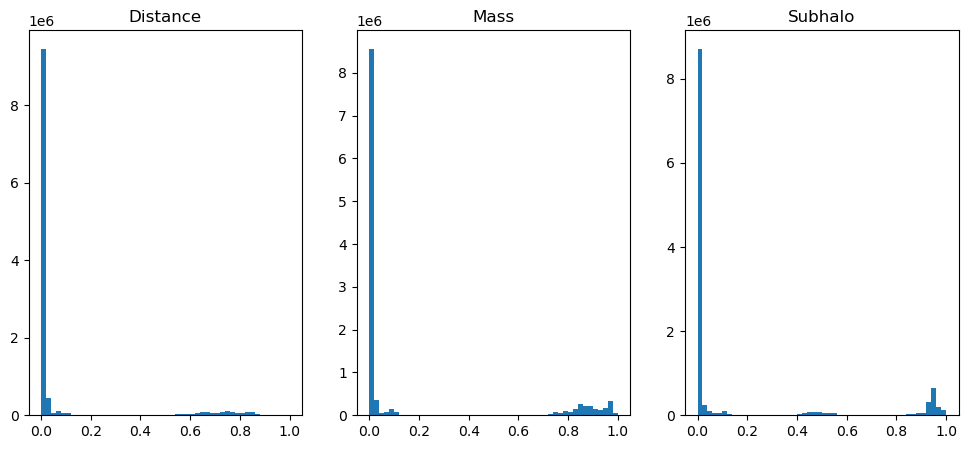

In [5]:
no_dist_data = transform(generated_data.to(dtype=torch.float))
no_dist_data = normalize(generated_data, True, [0, 1, 2])

dist = generated_data[:, 0]
mass = generated_data[:, 1]
subh = generated_data[:, 2]

fig, axs = plt.subplots(1, 3, figsize=(12, 5))

# Display the first image in the first subplot
axs[0].hist(dist.numpy().flatten(), bins = 50)
axs[0].set_title('Distance')

# Display the second image in the second subplot
axs[1].hist(mass.numpy().flatten(), bins = 50)
axs[1].set_title('Mass')

# Display the second image in the second subplot
axs[2].hist(subh.numpy().flatten(), bins = 50)
axs[2].set_title('Subhalo')

plt.show()



In [11]:
# dist
print("dist:")
lower_threshold = 0.2
upper_threshold = 0.4
count_between_thresholds = torch.sum((dist > lower_threshold) & (dist < upper_threshold)).item()
total_elements = dist.numel()
percentage_between_thresholds = (count_between_thresholds / total_elements) * 100
print(f"Percentage of values between {lower_threshold} and {upper_threshold}: {percentage_between_thresholds:.2f}%\n")

print("mass:")
lower_threshold = 0.2
upper_threshold = 0.6
count_between_thresholds = torch.sum((mass > lower_threshold) & (mass < upper_threshold)).item()
total_elements = mass.numel()
percentage_between_thresholds = (count_between_thresholds / total_elements) * 100
print(f"Percentage of values between {lower_threshold} and {upper_threshold}: {percentage_between_thresholds:.2f}%\n")

print("subh:")
lower_threshold = 0.25
upper_threshold = 0.35
count_between_thresholds = torch.sum((subh > lower_threshold) & (subh < upper_threshold)).item()
total_elements = subh.numel()
percentage_between_thresholds = (count_between_thresholds / total_elements) * 100
print(f"Percentage of values between {lower_threshold} and {upper_threshold}: {percentage_between_thresholds:.2f}%\n")
lower_threshold = 0.65
upper_threshold = 0.75
count_between_thresholds = torch.sum((subh > lower_threshold) & (subh < upper_threshold)).item()
total_elements = subh.numel()
percentage_between_thresholds = (count_between_thresholds / total_elements) * 100
print(f"Percentage of values between {lower_threshold} and {upper_threshold}: {percentage_between_thresholds:.2f}%\n")


dist:
Percentage of values between 0.2 and 0.4: 0.03%

mass:
Percentage of values between 0.2 and 0.6: 0.08%

subh:
Percentage of values between 0.25 and 0.35: 0.03%

Percentage of values between 0.65 and 0.75: 0.08%



In [12]:
test_new = transform_diffusion_image(generated_data, d_thresh = 0.3, m_tresh = 0.6, s_low = 0.3, s_high = 0.72)

original_min = 0.6985
mass = test_new[:, 1]
nonzero_indices = torch.nonzero(mass.flatten())
nonzero_mass = mass.flatten()[nonzero_indices[:, 0]]
print("mass:")
count_between_thresholds = torch.sum(nonzero_mass < original_min).item()
total_elements = mass.numel()
percentage_between_thresholds = (count_between_thresholds / total_elements) * 100
print(f"Percentage of values below {original_min}: {percentage_between_thresholds:.2f}%\n")

mass:
Percentage of values below 0.6985: 0.10%



In [13]:
variable_consistancy_check(test_new, False)
avg_branch = check_branch_length(test_new)
nearest_con, nearest_incon = check_consistency(test_new)

MASS:
monotonicity threshold = -1e-06% change
number of occurences where mass is not preserved = 629650
perc of occurences where mass is not preserved = 31.47% vs. 25.77% in training data




monotonicity threshold = -0.01% change
number of occurences where mass is not preserved = 360025
perc of occurences where mass is not preserved = 17.99% vs. 11.12% in training data




monotonicity threshold = -0.05% change
number of occurences where mass is not preserved = 153132
perc of occurences where mass is not preserved = 7.65% vs. 1.71% in training data




monotonicity threshold = -0.1% change
number of occurences where mass is not preserved = 87514
perc of occurences where mass is not preserved = 4.37% vs. 0.32% in training data







DISTANCE:
total distance progentors = 1106089 
number of occurences where distance increase (not preserved) = 575291
perc of occurences where mass increase (not preserved) = 52.01% vs. 49.67% in training data


total branches where the last halo distance t

MASS:
monotonicity threshold = -1e-06% change
number of occurences where mass is not preserved = 477071
perc of occurences where mass is not preserved = 31.33% vs. 25.77% in training data




monotonicity threshold = -0.01% change
number of occurences where mass is not preserved = 269221
perc of occurences where mass is not preserved = 17.68% vs. 11.12% in training data




monotonicity threshold = -0.05% change
number of occurences where mass is not preserved = 114218
perc of occurences where mass is not preserved = 7.50% vs. 1.71% in training data




monotonicity threshold = -0.1% change
number of occurences where mass is not preserved = 65075
perc of occurences where mass is not preserved = 4.27% vs. 0.32% in training data







DISTANCE:
total distance progentors = 835382 
number of occurences where distance increase (not preserved) = 436786
perc of occurences where mass increase (not preserved) = 52.29% vs. 49.67% in training data


total branches where the last halo distance to

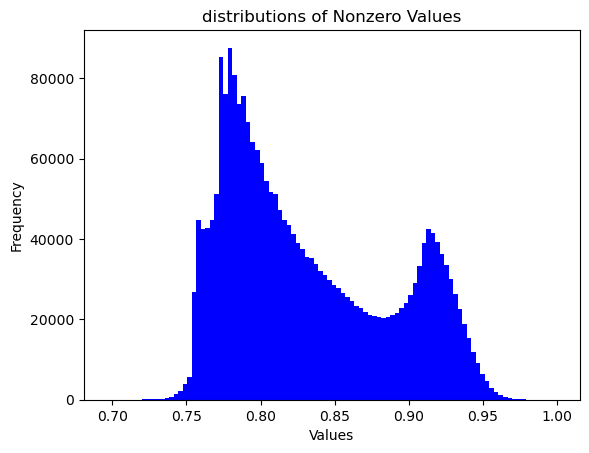

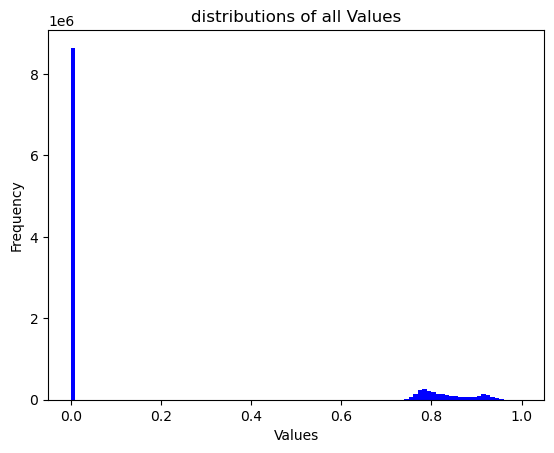

number of nonzero values = 2475374
Generated images:


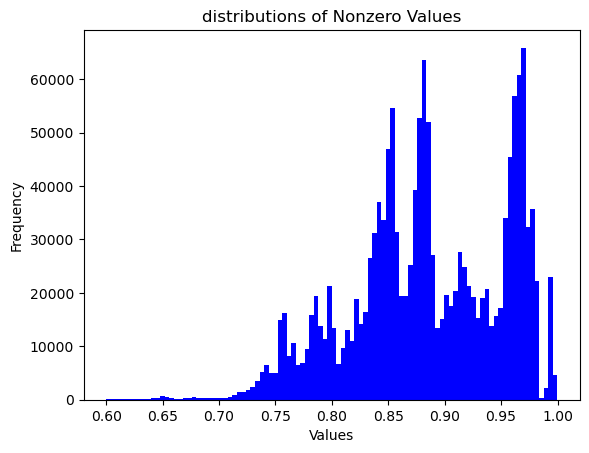

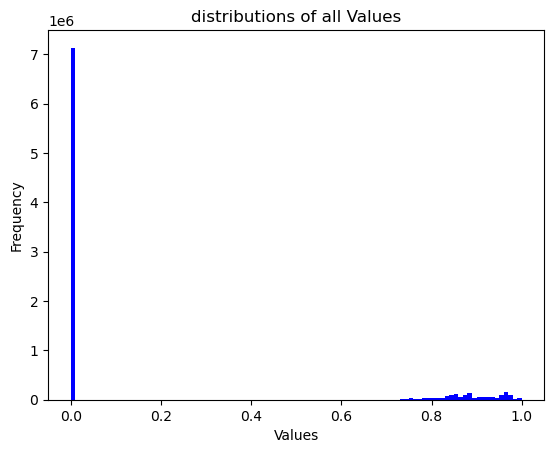

number of nonzero values = 1522691


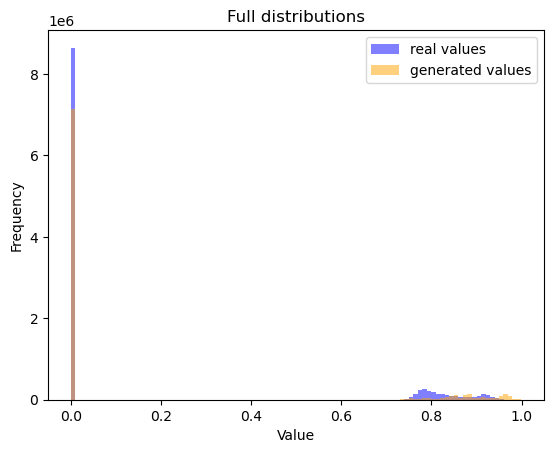

Full distribution:
KS Statistic: 0.05107167386299927
P-value: 0.0

According to regular significance level of 0.05:
The distributions are significantly different (reject H0)

According to large sample significance level of 0.05, giving significance level of 0.0006:
The distributions are significantly different (reject H0), KS statistic 0.0511 > 0.0006


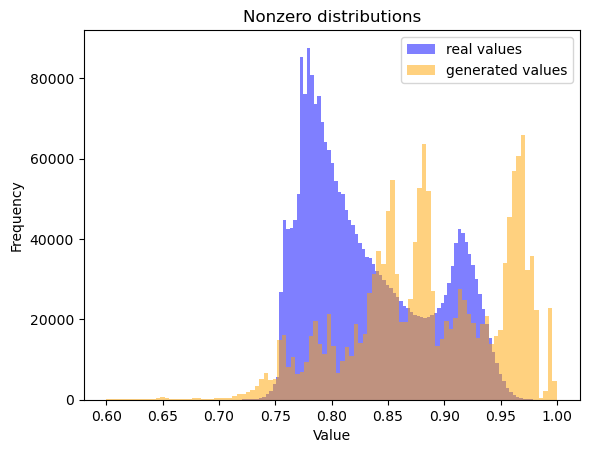

Nonzero distribution:
KS Statistic: 0.3863707257711667
P-value: 0.0

According to regular significance level of 0.05:
The distributions are significantly different (reject H0)

According to large sample significance level of 0.05, giving significance level of 0.0014:
The distributions are significantly different (reject H0), KS statistic 0.3864 > 0.0014


(0.05107167386299927, 0.3863707257711667)

In [17]:
variable_consistancy_check(nearest_con, False)
avg_branch = check_branch_length(nearest_con)
a, b = check_consistency(nearest_con)
comparing_data_path = "data/dataset_distlognorm_massnorm.pt"
original = torch.load(comparing_data_path)
ks_test(original, nearest_con, dim = 1)

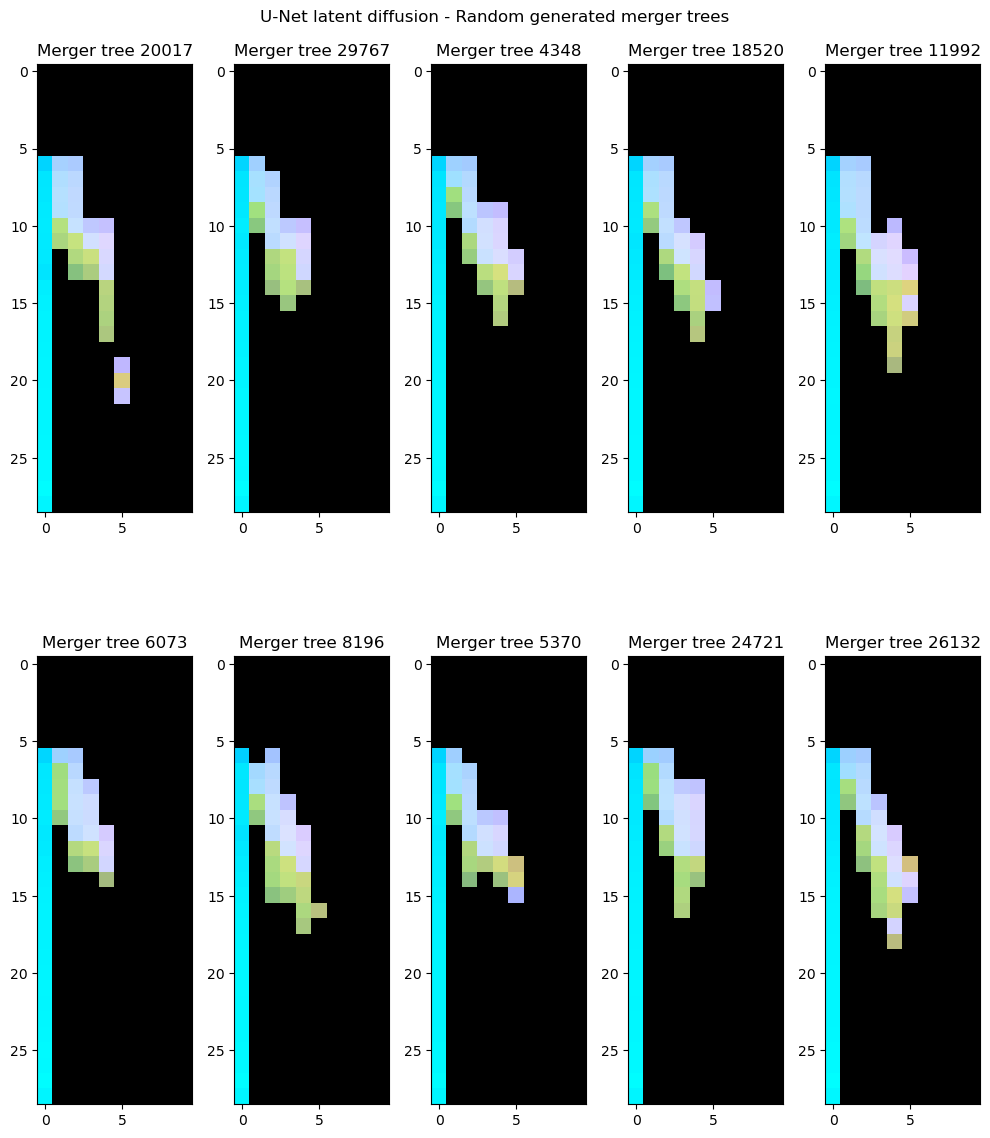

In [30]:
fig, axs = plt.subplots(2, 5, figsize=(10, 12))
axs = axs.flatten()
for j in range(10):
    i = random.randint(1, 30000)
    ax = axs[j]
    ax.imshow(nearest_con[i+j].permute(1, 2, 0))
    ax.set_title(f'Merger tree {i}')  # Set title for each image


# Adjust spacing between subplots
plt.tight_layout()
plt.suptitle('U-Net latent diffusion - Random generated merger trees')

# Show the plot
plt.show()